In [1]:
_exp_name = "sample"

In [2]:
# Import necessary packages.
import numpy as np
import torch
import os
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset

# This is for the progress bar.
from tqdm.auto import tqdm
import random

In [3]:
myseed = 6666  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

## **Transforms**
Torchvision provides lots of useful utilities for image preprocessing, data wrapping as well as data augmentation.

Please refer to PyTorch official website for details about different transforms.

In [4]:
# Normally, We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# However, it is also possible to use augmentation in the testing phase.
# You may use train_tfm to produce a variety of images and then test using ensemble methods
train_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation(50),
    transforms.GaussianBlur(3, 0.1),
    transforms.ColorJitter(brightness=0.5, hue=0.3),
    transforms.ToTensor(),
    #transforms.RandomApply(torch.nn.ModuleList([]))
    # You may add some transforms here.
    # ToTensor() should be the last one of the transforms.
])


# Q1. Augmentation Implementation Visualization

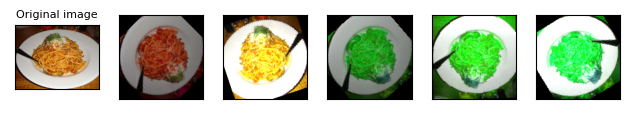

In [5]:
# I want to show you an example code of Q1. Augmentation Implementation that visualizes the effects of different image transformations.
import matplotlib.pyplot as plt

plt.rcParams["savefig.bbox"] = 'tight'

# You can change the file path to match your image
orig_img = Image.open('/kaggle/input/ml2023spring-hw3/test/0000.jpg')


def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

# Create a list of five transformed images from the original image using the train_tfm function
demo = [train_tfm(orig_img) for i in range(5)]

# Convert the transformed images from tensors to PIL images
pil_img_demo = [Image.fromarray(np.moveaxis(img.numpy()*255, 0, -1).astype(np.uint8)) for img in demo]

# Plot the transformed images using the plot function
plot(pil_img_demo) 

## **Datasets**
The data is labelled by the name, so we load images and label while calling '__getitem__'

In [5]:
class FoodDataset(Dataset):

    def __init__(self,path=None,tfm=test_tfm,files=None):
        super(FoodDataset).__init__()
        self.path = path
        if path:
            self.files = sorted([os.path.join(path, x) for x in os.listdir(path) if x.endswith(".jpg")])
        else:
            self.files = files
        self.transform = tfm
        print('Num of element: ', len(self.files))
  
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)
        #im = self.data[idx]
        try:
            label = int(fname.split("/")[-1].split("_")[0])
        except:
            label = -1 # test has no label
        return im,label

# Model

In [6]:
class Classifier(nn.Module):
   def __init__(self):
       super(Classifier, self).__init__()
       # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
       # torch.nn.MaxPool2d(kernel_size, stride, padding)
       # input 維度 [3, 128, 128]
       self.cnn = nn.Sequential(
           nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
           nn.BatchNorm2d(64),
           nn.ReLU(),
           nn.MaxPool2d(2, 2, 0),      # [64, 64, 64] 
          

           nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
           nn.BatchNorm2d(128),
           nn.ReLU(),
           nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]
         
           nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
           nn.BatchNorm2d(256),
           nn.ReLU(),
           nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

           nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
           nn.BatchNorm2d(512),
           nn.ReLU(),
           nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]
           
           nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
           nn.BatchNorm2d(512),
           nn.ReLU(),  
           nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
       )
       self.fc = nn.Sequential(
           nn.Dropout(0.4),
           nn.Linear(512*4*4, 1024),
           nn.ReLU(),
           nn.Linear(1024, 512),
           nn.ReLU(),
           nn.Linear(512, 11)
       )

   def forward(self, x):
       out = self.cnn(x)
       out = out.view(out.size()[0], -1)
       return self.fc(out)

# class Residual_Block(nn.Module):
#     def __init__(self, ic, oc, stride=1):
#         # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
#         # torch.nn.MaxPool2d(kernel_size, stride, padding)
#         super().__init__()
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(ic, oc, kernel_size=3, stride=stride, padding=1),
#             nn.BatchNorm2d(oc),
#             nn.ReLU(inplace=True)
#         )
        
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(oc, oc, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(oc),
#         )
        
#         self.relu = nn.ReLU(inplace=True)
    
#         self.downsample = None
#         if stride != 1 or (ic != oc):
#             self.downsample = nn.Sequential(
#                 nn.Conv2d(ic, oc, kernel_size=1, stride=stride),
#                 nn.BatchNorm2d(oc),
#             )
        
#     def forward(self, x):
#         residual = x
#         out = self.conv1(x)
#         out = self.conv2(out)
        
#         if self.downsample:
#             residual = self.downsample(x)
            
#         out += residual
#         return self.relu(out)
        
# class Classifier(nn.Module):
#     def __init__(self, block, num_layers, num_classes=11):
#         super().__init__()
#         self.preconv = nn.Sequential(
#             nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3, bias=False),
#             nn.BatchNorm2d(32),
#             nn.ReLU(inplace=True),
#         )
        
#         self.layer0 = self.make_residual(block, 32, 64,  num_layers[0], stride=2)
#         self.layer1 = self.make_residual(block, 64, 128, num_layers[1], stride=2)
#         self.layer2 = self.make_residual(block, 128, 256, num_layers[2], stride=2)
#         self.layer3 = self.make_residual(block, 256, 512, num_layers[3], stride=2)
        
#         #self.avgpool = nn.AvgPool2d(2)
        
#         self.fc = nn.Sequential(            
#             nn.Dropout(0.4),
#             nn.Linear(512*4*4, 512),
#             nn.BatchNorm1d(512),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.2),
#             nn.Linear(512, 11),
#         )
        
        
#     def make_residual(self, block, ic, oc, num_layer, stride=1):
#         layers = []
#         layers.append(block(ic, oc, stride))
#         for i in range(1, num_layer):
#             layers.append(block(oc, oc))
#         return nn.Sequential(*layers)
    
#     def forward(self, x):
#         # [3, 128, 128]
#         out = self.preconv(x)  # [32, 64, 64]
#         out = self.layer0(out) # [64, 32, 32]
#         out = self.layer1(out) # [128, 16, 16]
#         out = self.layer2(out) # [256, 8, 8]
#         out = self.layer3(out) # [512, 4, 4]
#         #out = self.avgpool(out) # [512, 2, 2]
#         out = self.fc(out.view(out.size(0), -1)) 
#         return out

# Loss

In [7]:
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, class_num, alpha=None, gamma=2, size_average=True):
        super().__init__()
        if alpha is None:
            self.alpha = Variable(torch.ones(class_num, 1))
        else:
            if isinstance(alpha, Variable):
                self.alpha = alpha
            else:
                self.alpha = Variable(alpha)
        self.gamma = gamma
        self.class_num = class_num
        self.size_average = size_average
        
    def forward(self, inputs, targets):
        N = inputs.size(0)
        C = inputs.size(1)
        P = F.softmax(inputs, dim=1)
        
        class_mask = inputs.data.new(N, C).fill_(0)
        class_mask = Variable(class_mask)
        ids = targets.view(-1, 1)
        class_mask.scatter_(1, ids.data, 1.)
        
        if inputs.is_cuda and not self.alpha.is_cuda:
            self.alpha = self.alpha.cuda()
        alpha = self.alpha[ids.data.view(-1)]
        probs = (P*class_mask).sum(1).view(-1, 1)
        
        log_p = probs.log()
        
        batch_loss = -alpha*(torch.pow((1-probs), self.gamma))*log_p
        
        if self.size_average:
            loss = batch_loss.mean()
        else:
            loss = batch_loss.sum()
            
        return loss
    
class MyCrossEntropy(nn.Module):
    def __init__(self, class_num):
        pass

# Config

In [8]:
batch_size = 64
num_layers = [2, 4, 3, 1] # residual number layers
alpha = torch.Tensor([1, 2.3, 0.66, 1, 1.1, 0.75, 2.3, 3.5, 1.1, 0.66, 1.4])

n_epochs = 30
patience = 16 # If no improvement in 'patience' epochs, early stop

k_fold = 4

# Dataloader

In [9]:
train_dir = "/kaggle/input/ml2023spring-hw3/train"
val_dir = "/kaggle/input/ml2023spring-hw3/valid"

train_files = [os.path.join(train_dir, x) for x in os.listdir(train_dir) if x.endswith('.jpg')]
val_files = [os.path.join(val_dir, x) for x in os.listdir(val_dir) if x.endswith('.jpg')]
total_files = train_files + val_files
random.shuffle(total_files)

num = len(total_files) // k_fold

# Start Training

In [ ]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# The number of training epochs and patience.


# Initialize a model, and put it on the device specified.

#from torchsummary import summary
#summary(model, (3, 128, 128))
# For the classification task, we use cross-entropy as the measurement of performance.
#criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.

# Initialize trackers, these are not parameters and should not be changed

test_fold = k_fold

for i in range(test_fold):
    fold = i+1
    print(f'\n\nStarting Fold: {fold} ********************************************')
    model = Classifier().to(device)
    criterion = FocalLoss(11, alpha=alpha)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0004, weight_decay=2e-5) 
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=16, T_mult=1)
    stale = 0
    best_acc = 0
    
    val_data = total_files[i*num: (i+1)*num]
    train_data = total_files[:i*num] + total_files[(i+1)*num:]
    
    train_set = FoodDataset(tfm=train_tfm, files=train_data)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
    
    valid_set = FoodDataset(tfm=test_tfm, files=val_data)
    valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
    
    for epoch in range(n_epochs):
    
        # ---------- Training ----------
        # Make sure the model is in train mode before training.
        model.train()
    
        # These are used to record information in training.
        train_loss = []
        train_accs = []
        lr = optimizer.param_groups[0]["lr"]
        
        pbar = tqdm(train_loader)
        pbar.set_description(f'T: {epoch+1:03d}/{n_epochs:03d}')
        for batch in pbar:
    
            # A batch consists of image data and corresponding labels.
            imgs, labels = batch
            #imgs = imgs.half()
            #print(imgs.shape,labels.shape)
    
            # Forward the data. (Make sure data and model are on the same device.)
            logits = model(imgs.to(device))
    
            # Calculate the cross-entropy loss.
            # We don't need to apply softmax before computing cross-entropy as it is done automatically.
            loss = criterion(logits, labels.to(device))
    
            # Gradients stored in the parameters in the previous step should be cleared out first.
            optimizer.zero_grad()
    
            # Compute the gradients for parameters.
            loss.backward()
    
            # Clip the gradient norms for stable training.
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
    
            # Update the parameters with computed gradients.
            optimizer.step()
    
            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
    
            # Record the loss and accuracy.
            train_loss.append(loss.item())
            train_accs.append(acc)
            pbar.set_postfix({'lr':lr, 'b_loss':loss.item(), 'b_acc':acc.item(),
                    'loss':sum(train_loss)/len(train_loss), 'acc': sum(train_accs).item()/len(train_accs)})
        
        scheduler.step()
        
        
        # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
        model.eval()
    
        # These are used to record information in validation.
        valid_loss = []
        valid_accs = []
    
        # Iterate the validation set by batches.
        pbar = tqdm(valid_loader)
        pbar.set_description(f'V: {epoch+1:03d}/{n_epochs:03d}')
        for batch in pbar:

            # A batch consists of image data and corresponding labels.
            imgs, labels = batch
            #imgs = imgs.half()
    
            # We don't need gradient in validation.
            # Using torch.no_grad() accelerates the forward process.
            with torch.no_grad():
                logits = model(imgs.to(device))
    
            # We can still compute the loss (but not the gradient).
            loss = criterion(logits, labels.to(device))
    
            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
    
            # Record the loss and accuracy.
            valid_loss.append(loss.item())
            valid_accs.append(acc)
            pbar.set_postfix({'v_loss':sum(valid_loss)/len(valid_loss), 
                              'v_acc': sum(valid_accs).item()/len(valid_accs)})
        
            #break
    
        # The average loss and accuracy for entire validation set is the average of the recorded values.
        valid_loss = sum(valid_loss) / len(valid_loss)
        valid_acc = sum(valid_accs) / len(valid_accs)
    
    
        if valid_acc > best_acc:
            print(f"Best model found at fold {fold} epoch {epoch+1}, acc={valid_acc:.5f}, saving model")
            torch.save(model.state_dict(), f"Fold_{fold}_best.ckpt")
            # only save best to prevent output memory exceed error
            best_acc = valid_acc
            stale = 0
        else:
            stale += 1
            if stale > patience:
                print(f"No improvment {patience} consecutive epochs, early stopping")
                break

# Dataloader for test

In [9]:
test_dir = "/kaggle/input/ml2023spring-hw3/test"
test_set = FoodDataset(test_dir, tfm=test_tfm)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

Num of element:  3000


In [ ]:
# test_dir = "/kaggle/input/ml2023spring-hw3/test"
# test_tfms = [test_tfm1, test_tfm2, test_tfm3, test_tfm4, test_tfm5]
# test_loaders = []
# for i in range(5):
#     test_set_i = FoodDataset(test_dir, tfm=train_tfm)
#     test_loader_i = DataLoader(test_set_i, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
#     test_loaders.append(test_loader_i)

## Testing and generate prediction CSV

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

models = []
for i in range(0, 4):
    fold = i + 1
    model_best = Classifier().to(device)
    model_best.load_state_dict(torch.load(f"Fold_{fold}_best.ckpt"))
    model_best.eval()
    models.append(model_best)

preds = [] 
with torch.no_grad():
    for data, _ in test_loader:
        batch_preds = [] 
        for model_best in models:
            batch_preds.append(model_best(data.to(device)).cpu().data.numpy())
        batch_preds = sum(batch_preds)
        preds.extend(batch_preds.squeeze().tolist())
        
preds = np.array(preds)
prediction = np.argmax(preds, axis=1)

In [ ]:
#create test csv
import pandas as pd
def pad4(i):
    return "0"*(4-len(str(i)))+str(i)
df = pd.DataFrame()
df["Id"] = [pad4(i) for i in range(1,len(test_set)+1)]
df["Category"] = prediction
df.to_csv("submission.csv",index = False)

# Q2. Visual Representations Implementation
## Visualize the learned visual representations of the CNN model on the validation set by implementing t-SNE (t-distributed Stochastic Neighbor Embedding) on the output of both top & mid layers (You need to submit 2 images). 

In [10]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.cm as cm
import torch.nn as nn

device = 'cpu' # 'cuda' if torch.cuda.is_available() else

# Load the trained model
model = Classifier().to(device)
state_dict = torch.load("/kaggle/input/fold-4-bestckpt/Fold_4_best.ckpt", map_location=device)
model.load_state_dict(state_dict)
model.eval()

print(model)

Classifier(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


Num of element:  3643


100%|██████████| 57/57 [00:58<00:00,  1.02s/it]
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


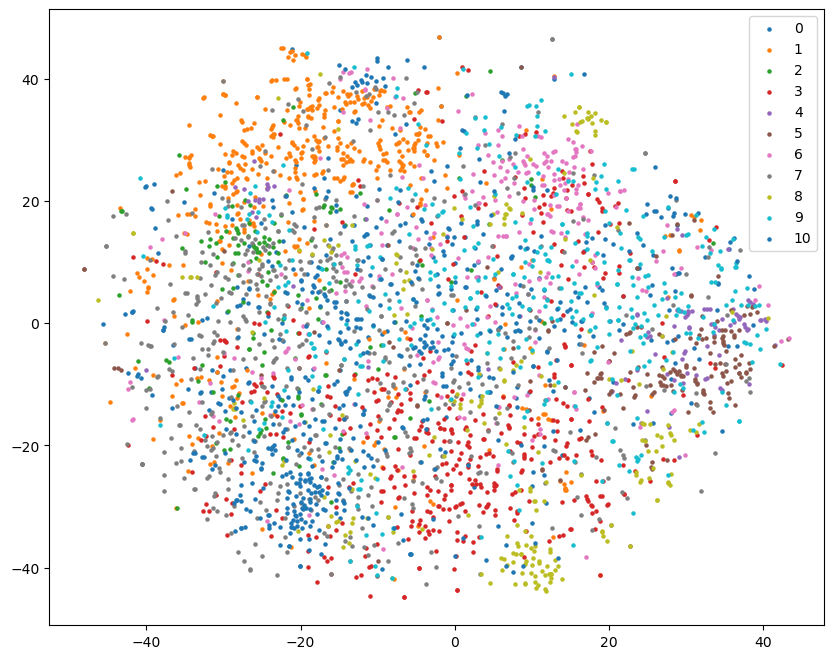

In [22]:
# Load the vaildation set defined by TA
valid_set = FoodDataset("/kaggle/input/ml2023spring-hw3/valid", tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

# Extract the representations for the specific layer of model
index = 19 # You should find out the index of layer which is defined as "top" or 'mid' layer of your model.
features = []
labels = []
for batch in tqdm(valid_loader):
    imgs, lbls = batch
    with torch.no_grad():
        logits = model.cnn[:index](imgs.to(device))
        logits = logits.view(logits.size()[0], -1)
    labels.extend(lbls.cpu().numpy())
    logits = np.squeeze(logits.cpu().numpy())
    features.extend(logits)
    
features = np.array(features)
colors_per_class = cm.rainbow(np.linspace(0, 1, 11))

# Apply t-SNE to the features
features_tsne = TSNE(n_components=2, init='pca', random_state=42).fit_transform(features)

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    plt.scatter(features_tsne[labels == label, 0], features_tsne[labels == label, 1], label=label, s=5)
plt.legend()
plt.show()

In [ ]:
# Load the vaildation set defined by TA
valid_set = FoodDataset("/kaggle/input/ml2023spring-hw3/valid", tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)
# Extract the representations for the specific layer of model
index = 1 # You should find out the index of layer which is defined as "top" or 'mid' layer of your model.
features = []
labels = []
for batch in tqdm(valid_loader):
    imgs, lbls = batch
    with torch.no_grad():
        logits = model.cnn[:index](imgs.to(device))
        logits = logits.view(logits.size()[0], -1)
    labels.extend(lbls.cpu().numpy())
    logits = np.squeeze(logits.cpu().numpy())
    features.extend(logits)
    
features = np.array(features)
colors_per_class = cm.rainbow(np.linspace(0, 1, 11))

# Apply t-SNE to the features
features_tsne = TSNE(n_components=2, init='pca', random_state=42).fit_transform(features)

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    plt.scatter(features_tsne[labels == label, 0], features_tsne[labels == label, 1], label=label, s=5)
plt.legend()
plt.show()

Num of element:  3643


100%|██████████| 57/57 [01:16<00:00,  1.35s/it]
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
